# Docs figure

Create the figure for the index page of the docs and GitHub.

## Import packages

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo", dpi_save=300, format="png")
scv.settings.plot_prefix = ""

cr.settings.verbosity = 2
cr.logging.print_version_and_date()

Running CellRank 1.0.0+gb3e00a8, on 2020-10-19 18:20.


## Import data

In [2]:
adata = cr.datasets.pancreas()
scv.utils.show_proportions(adata)
adata


Abundance of ['spliced', 'unspliced']: [0.81 0.19]


AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Pre-process the data

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Calculate the velocities

In [4]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:13:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [5]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Plot the velocities

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


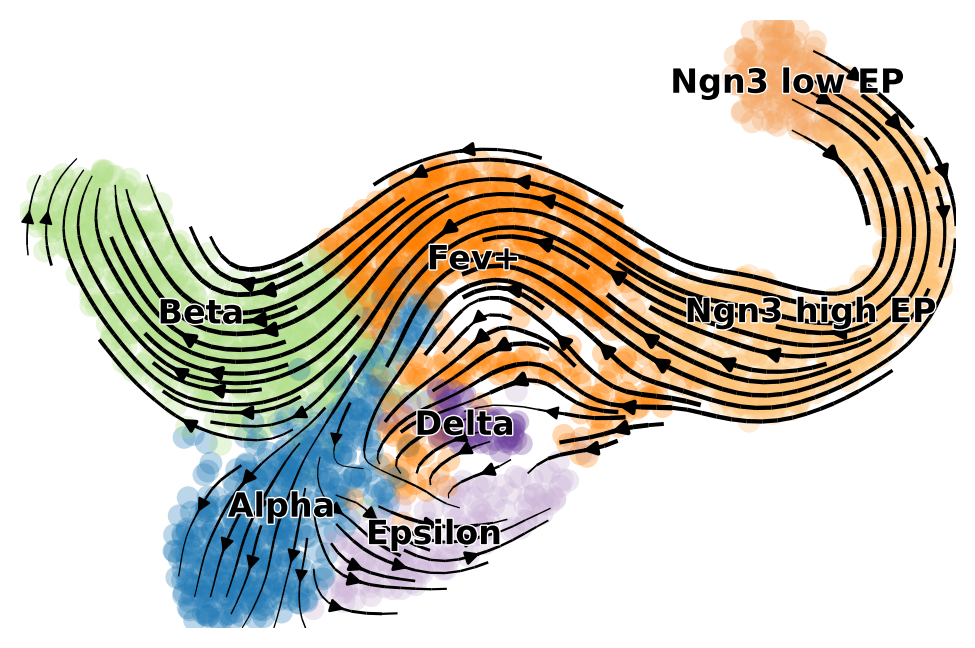

In [6]:
scv.pl.velocity_embedding_stream(adata, basis="umap", legend_fontsize=12, title='', smooth=.8, min_mass=4)

## Run CellRank

### Initialize the estimator

In [7]:
kernel = cr.tl.transition_matrix(adata,
                                 weight_connectivities=0.2,
                                 mode="stochastic",
                                 n_jobs=4,
                                 softmax_scale=None)

g_fwd = cr.tl.estimators.GPCCA(kernel)
g_fwd.compute_schur(10)

Computing transition matrix based on velocity correlations using `'stochastic'` mode
Estimating `softmax_scale` using `'deterministic'` mode



Setting `softmax_scale=3.9741`



    Finish (0:09:54)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on connectivities
    Finish (0:00:00)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 9]`
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:00)


### Compute macrostates, terminal states and absorption probabilities

In [9]:
g_fwd.compute_macrostates(cluster_key="clusters", n_states=10)
g_fwd.set_terminal_states_from_macrostates(names=["Alpha", "Beta", "Epsilon", "Delta"])
g_fwd.compute_absorption_probabilities()

Computing `10` macrostates
INFO: Using pre-computed schur decomposition
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:07)
Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
Computing absorption probabilities
Adding `adata.obsm['to_terminal_states']`
       `adata.obs['to_terminal_states_dp']`
       `.absorption_probabilities`
       `.diff_potential`
    Finish (0:00:00)


### Plot and save the absorption probabilities

saving figure to file ./figures/docs_figure.png


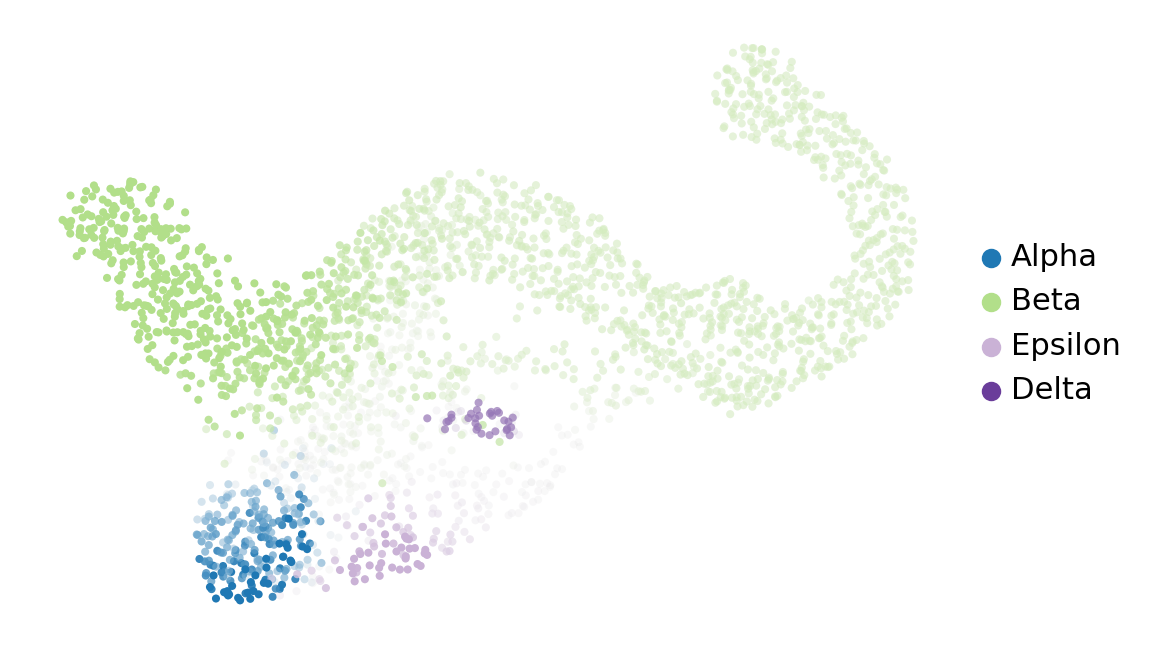

In [10]:
g_fwd.plot_absorption_probabilities(same_plot=True, legend_loc="right margin",
                                    title="", save="docs_figure")